In [1]:
%cd plant-disease-classification/

/teamspace/studios/this_studio/plant-disease-classification


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
ls

data/  models/  notebooks/  wandb/


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import random
import os
import PIL
import wandb
import time
from tqdm.auto import tqdm
import torchvision
import warnings

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.models import EfficientNet, EfficientNet_V2_L_Weights, EfficientNet_V2_S_Weights, EfficientNet_V2_M_Weights
from IPython.display import clear_output
from PIL import Image

warnings.filterwarnings("ignore")


In [ ]:
root_dir = "data/plantvillage dataset"
os.listdir(root_dir)

['color', 'grayscale', 'segmented']

In [ ]:
color_set = set(os.listdir(os.path.join(root_dir, "color")))
segmented_set = set(os.listdir(os.path.join(root_dir, "segmented")))
grayscale_set = set(os.listdir(os.path.join(root_dir, "grayscale")))

color_set == segmented_set == grayscale_set
                    
                

True

In [6]:
color_set

{'Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [ ]:
len(color_set)

38

# Custom Dataset Creation

In [8]:
# Example usage
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
color_dir = os.path.join(root_dir, "color")
segmented_dir = os.path.join(root_dir, "segmented")
grayscale_dir = os.path.join(root_dir, "grayscale")

In [10]:
color_data = ImageFolder(color_dir)

In [11]:
len(color_data)

54305

In [12]:
from torch.utils.data import random_split


train_size = int(0.8 * len(color_data))
val_size = len(color_data) - train_size

color_train_dataset, color_val_dataset = random_split(color_data, [train_size, val_size])

In [13]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = self.transform(img)
        return img, label

In [14]:
color_train_data = TransformedDataset(color_train_dataset, transform=train_transforms)
color_val_data = TransformedDataset(color_val_dataset, transform=val_transforms)

color_train_loader = DataLoader(color_train_data, batch_size=64, shuffle=True, num_workers=4)
color_val_loader = DataLoader(color_val_data, batch_size=32, shuffle=False, num_workers=4)

In [15]:
image, label = next(iter(color_train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


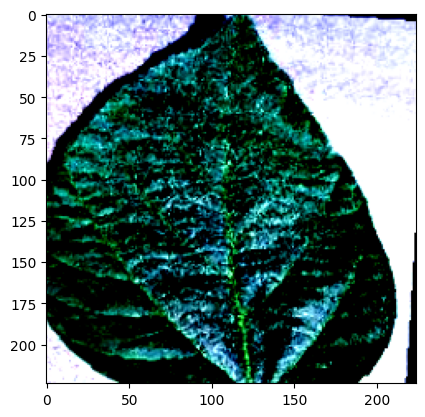

In [16]:
plt.imshow(image[1].permute(1, 2, 0))

# EDA

In [17]:
def plot_and_log_class_images(root_dir, class_name, transforms=None):
    """
    Plots random images from color, segmented, and grayscale directories for a given class.
    If transforms are None, plots only original images (1 row, 3 columns).
    If transforms are provided, plots both original and transformed (2 rows, 3 columns).
    Logs the plot to W&B.
    """
    # Paths to the directories
    color_dir = os.path.join(root_dir, 'color', class_name)
    segmented_dir = os.path.join(root_dir, 'segmented', class_name)
    grayscale_dir = os.path.join(root_dir, 'grayscale', class_name)

    # List of images (ensure the corresponding files exist in all three folders)
    color_images = os.listdir(color_dir)
    segmented_images = os.listdir(segmented_dir)
    grayscale_images = os.listdir(grayscale_dir)

    # Pick a random image from the available ones in each directory
    random_idx = random.randint(0, len(color_images) - 1)
    color_img_path = os.path.join(color_dir, color_images[random_idx])
    segmented_img_path = os.path.join(segmented_dir, segmented_images[random_idx])
    grayscale_img_path = os.path.join(grayscale_dir, grayscale_images[random_idx])

    # Load images
    color_img = Image.open(color_img_path)
    segmented_img = Image.open(segmented_img_path)
    grayscale_img = Image.open(grayscale_img_path)

    if transforms:
        # Apply transformations if provided
        transformed_color_img = transforms(color_img)
        transformed_segmented_img = transforms(segmented_img)
        transformed_grayscale_img = transforms(grayscale_img)

        # Create a subplot with 2 rows and 3 columns (original + transformed)
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))

        # First row: Original images
        ax[0, 0].imshow(color_img)
        ax[0, 0].set_title("Color (Original)")
        ax[0, 0].axis('off')

        ax[0, 1].imshow(segmented_img)
        ax[0, 1].set_title("Segmented (Original)")
        ax[0, 1].axis('off')

        ax[0, 2].imshow(grayscale_img, cmap='gray')
        ax[0, 2].set_title("Grayscale (Original)")
        ax[0, 2].axis('off')

        # Second row: Transformed images
        ax[1, 0].imshow(transformed_color_img.permute(1, 2, 0))
        ax[1, 0].set_title("Color (Transformed)")
        ax[1, 0].axis('off')

        ax[1, 1].imshow(transformed_segmented_img.permute(1, 2, 0))
        ax[1, 1].set_title("Segmented (Transformed)")
        ax[1, 1].axis('off')

        ax[1, 2].imshow(transformed_grayscale_img.permute(1, 2, 0), cmap='gray')
        ax[1, 2].set_title("Grayscale (Transformed)")
        ax[1, 2].axis('off')

    else:
        # Create a subplot with 1 row and 3 columns (only original images)
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(color_img)
        ax[0].set_title("Color (Original)")
        ax[0].axis('off')

        ax[1].imshow(segmented_img)
        ax[1].set_title("Segmented (Original)")
        ax[1].axis('off')

        ax[2].imshow(grayscale_img, cmap='gray')
        ax[2].set_title("Grayscale (Original)")
        ax[2].axis('off')

    # Log the plot to W&B
    wandb.log({f"{class_name}_images": wandb.Image(fig, caption=f"{class_name} Images")})
    
    # Close the figure after logging to avoid memory issues
    plt.close(fig)

def traverse_and_log(root_dir, name, transforms=None):
    """
    Traverses through all classes in the dataset, and for each class,
    plots random images from color, segmented, and grayscale directories.
    Logs each plot to W&B.
    """
    # Initialize W&B run (ensure you have already initialized W&B in your script)
    wandb.init(project="plant-disease-classification", name=name)

    # Get all classes (directories) in the color folder
    color_classes = os.listdir(os.path.join(root_dir, 'color'))

    # Traverse each class and plot images
    for class_name in color_classes:
        plot_and_log_class_images(root_dir, class_name, transforms)
    
    wandb.finish()

In [18]:
traverse_and_log(root_dir, name="Normalized Transforms", transforms=train_transforms)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kaus1kc0des (zer0ne). Use `wandb login --relogin` to force relogin


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

# Hyper Parameters

In [19]:
hyperparameters = {
    "train_bs": 64,
    "val_bs": 32,
    "epochs":10,
    "lr": 1e-4,
    "weight_decay": 1e-6,
    "momentum": 0.9,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "num_classes": len(color_data.classes)
}

# Model Creation

In [20]:
class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseClassifier, self).__init__()
        # Load EfficientNetB0 model
        self.base_model = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)
        
        # Modify classifier to match the number of classes
        num_ftrs = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Number of output classes
        )

    def forward(self, x):
        return self.base_model(x)

    # Method to plot training history
    def plot_history(self, history):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(history['train_accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

        plt.show()

    # Method to calculate accuracy
    def accuracy_fn(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        correct = (preds == labels).float()
        accuracy = correct.sum() / len(correct)
        return accuracy

    # Training method
    def train_model(self, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0):
        self.to(device)
        history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
        
        for epoch in range(epochs):
            self.train()  # Set model to training mode
            train_loss = 0
            train_accuracy = 0
            train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=True)
            
            # Training loop
            for inputs, labels in train_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                train_preds = self(inputs)
                loss = criterion(train_preds, labels)
                train_loss += loss.item() * inputs.size(0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_accuracy += self.accuracy_fn(train_preds, labels).item() * inputs.size(0)
            
            train_loss /= len(train_loader.dataset)
            train_accuracy /= len(train_loader.dataset)
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            
            
            # Validation loop
            self.eval()  # Set model to evaluation mode
            val_loss = 0
            val_accuracy = 0
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=True)
            
            with torch.no_grad():
                for inputs, labels in val_loader_tqdm:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    val_accuracy += self.accuracy_fn(outputs, labels).item() * inputs.size(0)
            
            val_loss /= len(val_loader.dataset)
            val_accuracy /= len(val_loader.dataset)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
            
            # Log validation metrics to W&B
            wandb.log({"train_loss":train_loss, "val_loss":val_loss, "epochs":epoch+1})
            wandb.log({"train_accuracy":train_accuracy, "val_accuracy":val_accuracy, "epochs":epoch+1})
            
            tqdm.write(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
            
            time.sleep(5)  # To ensure tqdm prints properly
            self.plot_history(history)  # Plot the training and validation metrics after each epoch

        return history, self

# Training and Logging

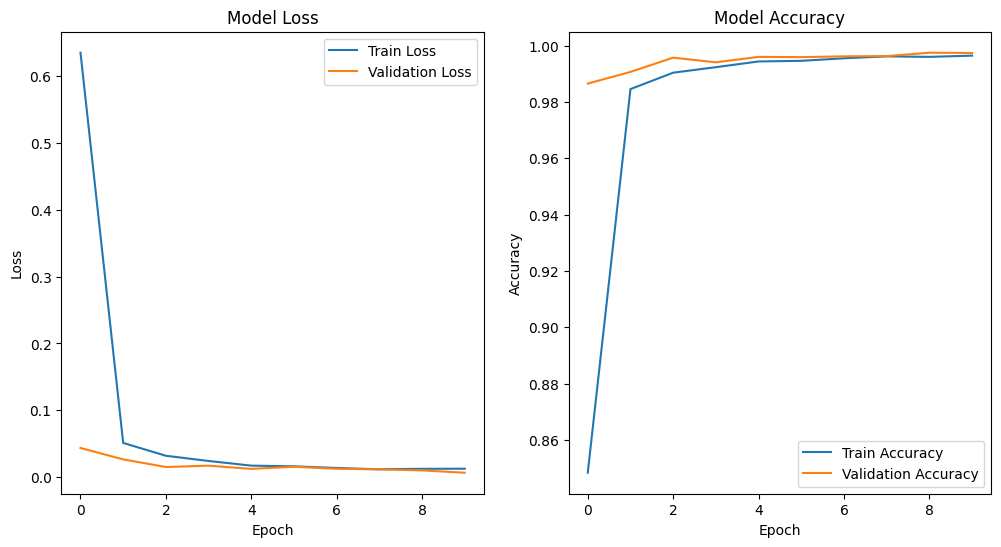

epochs,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_accuracy,▁▇████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▇▆▇▇▇▇██
val_loss,█▅▃▃▂▃▂▂▂▁
epochs,10
train_accuracy,0.99648
train_loss,0.01275
val_accuracy,0.99742
val_loss,0.00675


In [21]:
wandb.init(project='plant-disease-classification', name="EffNet_L_Training", config=hyperparameters)

model = PlantDiseaseClassifier(hyperparameters['num_classes'])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

history, model = model.train_model(criterion, optimizer, color_train_loader, color_val_loader, hyperparameters['epochs'],hyperparameters['device'])

# Finish the W&B run
wandb.finish()

In [24]:
torch.save(model.state_dict(), "models/effnet_l_weights.pth")

In [26]:
wandb.init(project='plant-disease-classification', name="EffNet_L_weights")
wandb.save("models/effnet_l_weights.pth")
wandb.finish()